# Import Libraries

In [ ]:
Hello

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

c:\Users\noppa\anaconda3\envs\dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameter Setting

In [2]:
# For shuffle
SEED = 42

In [3]:
# For feature engineering
t_d = 30 # detection time
t_w = 10 # time windows

In [4]:
# For model
EPOCH = 30
BATCHSIZE = 32
VAL = 0.2

# Function for ViT

In [5]:
# Create NumpyDataset class for using with ViT
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data[:, :, :, :3].astype(np.float32) # Select only RGB channel
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Swap from (Height, Width, Channel) to (Channel, Width, Height)
])

In [7]:
def evaluate(model, dataloader, device):
    model.eval() 
    all_predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) # Get class with the highest probability
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_predictions)

# Load Data

In [8]:
BASE = 'C:/Users/noppa/Downloads/CCU_Internship/program'

In [9]:
DATAPATH = 'RanSAP/dataset/original/win7-250gb-ssd'

In [10]:
os.chdir(f'{BASE}/{DATAPATH}')
labels = sorted(os.listdir())
print(labels)

['AESCrypt', 'Cerber', 'Darkside', 'Excel', 'Firefox', 'GandCrab4', 'Ryuk', 'SDelete', 'Sodinokibi', 'TeslaCrypt', 'WannaCry', 'Zip']


In [11]:
benign = ['AESCrypt', 'Zip', 'SDelete', 'Excel', 'Firefox']
ransomware = ['TeslaCrypt', 'Cerber', 'WannaCry', 'GandCrab4', 'Ryuk', 'Sodinokibi', 'Darkside']

In [12]:
X_train = []
X_test = []
y1_train = []
y1_test = []

In [13]:
np.random.seed(SEED)
for label in labels:
    os.chdir(f'{BASE}/{DATAPATH}/{label}')
    dirs = sorted(os.listdir())
    dirs = np.array(dirs)
    # Shuffle directory
    np.random.seed(SEED)
    np.random.shuffle(dirs)
    train_idx = int(len(dirs)*0.8)

    for dir_idx in range(len(dirs)):
        print(dirs[dir_idx])
        os.chdir(f'{BASE}/{DATAPATH}/{label}/{dirs[dir_idx]}')
        files = sorted(os.listdir())
        tmp = []
        
        for i in range(t_d - t_w):
            df_r = pd.read_csv(f'{BASE}/{DATAPATH}/{label}/{dirs[dir_idx]}/{files[0]}', header=None)
            df_w = pd.read_csv(f'{BASE}/{DATAPATH}/{label}/{dirs[dir_idx]}/{files[1]}', header=None)
            timestamp_r = np.unique(df_r[0])
            timestamp_w = np.unique(df_w[0])

            filtered_df_r = df_r[(df_r[0] >= timestamp_r[i]) & (df_r[0] < timestamp_r[i+t_w])]
            filtered_df_w = df_w[(df_w[0] >= timestamp_w[i]) & (df_w[0] < timestamp_w[i+t_w])]

            # average write throughput [byte/s]
            T_write = np.sum(filtered_df_w[3])/t_w

            # average read throughput [byte/s]
            T_read = np.sum(filtered_df_r[3])/t_w

            # variance of logical block addresses (written)
            V_write_mean = np.mean(filtered_df_w[2])
            V_write = (1/(t_w-1)) * np.sum((filtered_df_w[2]-V_write_mean)**2)

            # variance of logical block addresses (read)
            V_read_mean = np.mean(filtered_df_r[2])
            V_read = (1/(t_w-1)) * np.sum((filtered_df_r[2]-V_read_mean)**2)

            # average normalized Shannon entropy
            H_write = (1/t_w) * np.sum(filtered_df_w[4])

            tmp.append([T_write, T_read, V_write, V_read, H_write])

        # Train-Test split
        if dir_idx < train_idx:
            X_train.append(tmp)
            y1_train.append(label)
        else:
            X_test.append(tmp)
            y1_test.append(label)

AESCrypt-20200526_01-36-31
AESCrypt-20200526_00-39-43
AESCrypt-20200526_01-21-48
AESCrypt-20200526_00-32-39
AESCrypt-20200526_01-32-14
AESCrypt-20200526_00-44-12
AESCrypt-20200526_01-40-49
AESCrypt-20200526_01-14-14
AESCrypt-20200526_01-09-55
AESCrypt-20200526_01-27-25
Cerber-20200807_18-23-01
Cerber-20200807_00-51-59
Cerber-20200807_17-55-29
Cerber-20200807_01-01-20
Cerber-20200729_03-55-43
Cerber-20200729_04-01-34
Cerber-20200807_18-27-51
Cerber-20200807_18-07-10
Cerber-20200807_00-37-14
Cerber-20200729_03-12-29
Cerber-20200729_03-32-47
Cerber-20200807_00-56-53
Cerber-20200729_03-37-19
Cerber-20200807_00-42-11
Cerber-20200807_00-32-25
Cerber-20200807_17-50-11
Cerber-20200729_03-17-52
Cerber-20200729_03-23-39
Cerber-20200807_18-12-13
Cerber-20200729_03-28-14
Cerber-20200807_17-44-02
Cerber-20200807_18-16-47
Cerber-20200807_01-06-08
Cerber-20200807_18-32-30
Cerber-20200807_17-35-55
Cerber-20200729_03-46-38
Cerber-20200807_00-27-33
Cerber-20200807_00-46-51
Cerber-20200807_01-12-29
Cerbe

In [14]:
X_train = np.array(X_train)
y1_train = np.array(y1_train)
X_test = np.array(X_test)
y1_test = np.array(y1_test)
print(X_train.shape)
print(y1_train.shape)
print(X_test.shape)
print(y1_test.shape)

(208, 20, 5)
(208,)
(53, 20, 5)
(53,)


# Data Preprocessing

## Min-Max Normalization

In [15]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_reshaped.shape

(4160, 5)

In [16]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_reshaped.shape

(1060, 5)

In [17]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)

In [18]:
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_test_normalized = X_test_normalized.reshape(X_test.shape)

In [19]:
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(208, 20, 5)
(53, 20, 5)


## Label Encoder

In [20]:
y_train = []

for y in y1_train:
    if y in benign:
        y_train.append('Benign')
    else:
        y_train.append('Ransomware')

In [21]:
y_test = []

for y in y1_test:
    if y in benign:
        y_test.append('Benign')
    else:
        y_test.append('Ransomware')

In [22]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
lbl = LabelEncoder()

In [24]:
classes, count = np.unique(y_train, return_counts=True)
print(classes)
print(count)

['Benign' 'Ransomware']
[ 40 168]


In [25]:
print(lbl.fit_transform(classes), classes)
y_train_int = lbl.fit_transform(y_train)
y_train_int.shape

[0 1] ['Benign' 'Ransomware']


(208,)

In [26]:
classes_test, count_test = np.unique(y_test, return_counts=True)
print(classes_test)
print(count_test)

['Benign' 'Ransomware']
[11 42]


In [27]:
y_test_int = lbl.transform(y_test)
y_test_int.shape

(53,)

## Data Augmentation

In [28]:
data_train_flattened = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
data_train_flattened.shape

(208, 100)

In [29]:
np.random.seed(SEED)
smote = SMOTE(sampling_strategy='auto', random_state=SEED) # Resample benign class to be equal to ransomware class
data_train_resampled_flattened, y_train_int_aug = smote.fit_resample(data_train_flattened, y_train_int)

In [30]:
X_train_normalized_aug = data_train_resampled_flattened.reshape(data_train_resampled_flattened.shape[0], X_train_normalized.shape[1], X_train_normalized.shape[2])
X_train_normalized_aug.shape

(336, 20, 5)

# Time series as an Input

## Shuffle Data

In [34]:
np.random.seed(SEED)
perm = np.random.permutation(X_train_normalized.shape[0])
perm_aug = np.random.permutation(X_train_normalized_aug.shape[0])
perm_test = np.random.permutation(X_test_normalized.shape[0])

In [35]:
X_train_normalized = X_train_normalized[perm]
y_train_int = y_train_int[perm]

In [36]:
X_train_normalized_aug = X_train_normalized_aug[perm_aug]
y_train_int_aug = y_train_int_aug[perm_aug]

In [37]:
X_test_normalized = X_test_normalized[perm_test]
y_test_int = y_test_int[perm_test]

In [38]:
NUMCLASS = len(classes)

## LSTM

In [39]:
tf.random.set_seed(SEED)
lstm = Sequential(name='LSTM')
lstm.add(LSTM(16, activation='tanh', input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2])))
lstm.add(Dense(NUMCLASS, activation='softmax'))

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1408      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 1,442
Trainable params: 1,442
Non-trainable params: 0
_________________________________________________________________


In [41]:
tf.random.set_seed(SEED)
lstm_history = lstm.fit(X_train_normalized, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
6/6 [==============================] - 4s 143ms/step - loss: 0.7041 - accuracy: 0.3193 - val_loss: 0.6950 - val_accuracy: 0.4048
Epoch 2/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6870 - accuracy: 0.6747 - val_loss: 0.6776 - val_accuracy: 0.8095
Epoch 3/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6706 - accuracy: 0.8494 - val_loss: 0.6602 - val_accuracy: 0.8095
Epoch 4/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6531 - accuracy: 0.8313 - val_loss: 0.6418 - val_accuracy: 0.7857
Epoch 5/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6354 - accuracy: 0.8133 - val_loss: 0.6201 - val_accuracy: 0.7857
Epoch 6/30
6/6 [==============================] - 0s 14ms/step - loss: 0.6134 - accuracy: 0.8133 - val_loss: 0.5950 - val_accuracy: 0.7857
Epoch 7/30
6/6 [==============================] - 0s 13ms/step - loss: 0.5864 - accuracy: 0.8133 - val_loss: 0.5690 - val_accuracy: 0.7857
Epoch 8/30
6/6 [==========

In [42]:
lstm.save(f'{BASE}/Models/lstm.h5')

## LSTM with SMOTE

In [43]:
tf.random.set_seed(SEED)
lstm_aug = Sequential(name='LSTM_aug')
lstm_aug.add(LSTM(16, activation='tanh', input_shape=(X_train_normalized_aug.shape[1], X_train_normalized_aug.shape[2])))
lstm_aug.add(Dense(NUMCLASS, activation='softmax'))

lstm_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
lstm_aug.summary()

Model: "LSTM_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1408      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,442
Trainable params: 1,442
Non-trainable params: 0
_________________________________________________________________


In [45]:
tf.random.set_seed(SEED)
lstm_aug_history = lstm_aug.fit(X_train_normalized_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
9/9 [==============================] - 3s 85ms/step - loss: 0.6927 - accuracy: 0.5858 - val_loss: 0.6896 - val_accuracy: 0.6471
Epoch 2/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6893 - accuracy: 0.5933 - val_loss: 0.6837 - val_accuracy: 0.5882
Epoch 3/30
9/9 [==============================] - 0s 15ms/step - loss: 0.6849 - accuracy: 0.5858 - val_loss: 0.6765 - val_accuracy: 0.5882
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6800 - accuracy: 0.5896 - val_loss: 0.6667 - val_accuracy: 0.5882
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6717 - accuracy: 0.6045 - val_loss: 0.6511 - val_accuracy: 0.5882
Epoch 6/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6601 - accuracy: 0.6455 - val_loss: 0.6287 - val_accuracy: 0.6618
Epoch 7/30
9/9 [==============================] - 0s 12ms/step - loss: 0.6463 - accuracy: 0.6679 - val_loss: 0.6070 - val_accuracy: 0.6471
Epoch 8/30
9/9 [===========

In [46]:
lstm_aug.save(f'{BASE}/Models/lstm_aug.h5')

# Evaluation

## LSTM

In [47]:
tf.random.set_seed(SEED)
lstm_pred = lstm.predict(X_test_normalized)

2/2 [==============================] - 1s 16ms/step


In [48]:
lstm_pred_int = np.argmax(lstm_pred, axis=1)

In [49]:
print('Accuracy:', accuracy_score(y_test_int, lstm_pred_int))
print('Precision:', precision_score(y_test_int, lstm_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, lstm_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, lstm_pred_int, average='macro'))

Accuracy: 0.8301886792452831
Precision: 0.9117647058823529
Recall: 0.5909090909090909
F1-Score: 0.6054590570719602


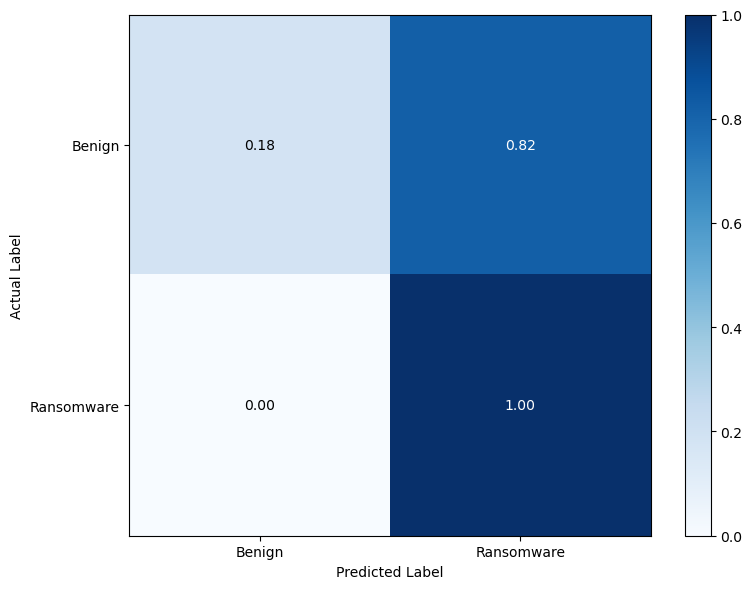

In [50]:
confusionMatrix_lstm = confusion_matrix(y_test_int, lstm_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_lstm, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_lstm.shape[0]):
    for j in range(confusionMatrix_lstm.shape[1]):
        plt.text(j, i, format(confusionMatrix_lstm[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_lstm[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

## LSTM with SMOTE

In [51]:
tf.random.set_seed(SEED)
lstm_aug_pred = lstm_aug.predict(X_test_normalized)

2/2 [==============================] - 0s 0s/step


In [52]:
lstm_aug_pred_int = np.argmax(lstm_aug_pred, axis=1)

In [53]:
print('Accuracy:', accuracy_score(y_test_int, lstm_aug_pred_int))
print('Precision:', precision_score(y_test_int, lstm_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, lstm_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, lstm_aug_pred_int, average='macro'))

Accuracy: 0.8867924528301887
Precision: 0.8434343434343434
Recall: 0.7943722943722944
F1-Score: 0.8151162790697675


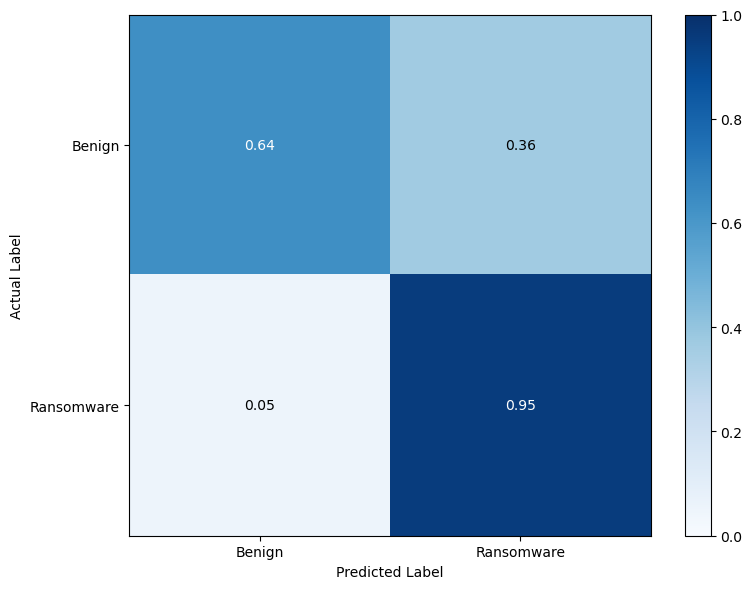

In [54]:
confusionMatrix_lstm_aug = confusion_matrix(y_test_int, lstm_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_lstm_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_lstm_aug.shape[0]):
    for j in range(confusionMatrix_lstm_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_lstm_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_lstm_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

# Image as an Input

In [55]:
PLOTSIZE = 16 # Size of GAF and MTF image
IMAGESIZE = 64 # Size of image loaded from buffer

In [56]:
data_train_transposed = np.transpose(X_train_normalized, (0, 2, 1))
data_train_transposed.shape

(208, 5, 20)

In [57]:
data_train_aug_transposed = np.transpose(X_train_normalized_aug, (0, 2, 1))
data_train_aug_transposed.shape

(336, 5, 20)

In [58]:
data_test_transposed = np.transpose(X_test_normalized, (0, 2, 1))
data_test_transposed.shape

(53, 5, 20)

## Gramian Angular Field

In [59]:
gaf0 = GramianAngularField(image_size=PLOTSIZE)
gaf1 = GramianAngularField(image_size=PLOTSIZE)
gaf2 = GramianAngularField(image_size=PLOTSIZE)
gaf3 = GramianAngularField(image_size=PLOTSIZE)
gaf4 = GramianAngularField(image_size=PLOTSIZE)

In [60]:
gaf_train_f0 = gaf0.fit_transform(data_train_transposed[:, 0, :])
gaf_train_f1 = gaf1.fit_transform(data_train_transposed[:, 1, :])
gaf_train_f2 = gaf2.fit_transform(data_train_transposed[:, 2, :])
gaf_train_f3 = gaf3.fit_transform(data_train_transposed[:, 3, :])
gaf_train_f4 = gaf4.fit_transform(data_train_transposed[:, 4, :])

In [61]:
gaf_train = np.empty((data_train_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            # Average all values in the same position
            gaf_train[i][j][k] = (gaf_train_f0[i][j][k] + gaf_train_f1[i][j][k] + gaf_train_f2[i][j][k] + gaf_train_f3[i][j][k] + gaf_train_f4[i][j][k])/5

In [62]:
gaf_img_train_tmp = []

for g in gaf_train:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_train_tmp.append(image_array)

In [63]:
gaf_img_train = np.stack(gaf_img_train_tmp, axis=0)
gaf_img_train = gaf_img_train/255
gaf_img_train.shape

(208, 64, 64, 4)

In [64]:
gaf_test_f0 = gaf0.transform(data_test_transposed[:, 0, :])
gaf_test_f1 = gaf1.transform(data_test_transposed[:, 1, :])
gaf_test_f2 = gaf2.transform(data_test_transposed[:, 2, :])
gaf_test_f3 = gaf3.transform(data_test_transposed[:, 3, :])
gaf_test_f4 = gaf4.transform(data_test_transposed[:, 4, :])

In [65]:
gaf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_test[i][j][k] = (gaf_test_f0[i][j][k] + gaf_test_f1[i][j][k] + gaf_test_f2[i][j][k] + gaf_test_f3[i][j][k] + gaf_test_f4[i][j][k])/5

In [66]:
gaf_img_test_tmp = []

for g in gaf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_test_tmp.append(image_array)

In [67]:
gaf_img_test = np.stack(gaf_img_test_tmp, axis=0)
gaf_img_test = gaf_img_test/255
gaf_img_test.shape

(53, 64, 64, 4)

### CNN

In [68]:
tf.random.set_seed(SEED)
cnn_gaf = Sequential(name='CNN_GAF')
cnn_gaf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(gaf_img_train.shape[1], gaf_img_train.shape[2], gaf_img_train.shape[3])))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Dropout(0.2))
cnn_gaf.add(Conv2D(16, (3, 3), activation='relu'))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Dropout(0.2))
cnn_gaf.add(Conv2D(8, (3, 3), activation='relu'))
cnn_gaf.add(MaxPooling2D((2, 2)))
cnn_gaf.add(Flatten())
cnn_gaf.add(Dense(8, activation='relu'))
cnn_gaf.add(Dense(NUMCLASS, activation='softmax'))

cnn_gaf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
cnn_gaf.summary()

Model: "CNN_GAF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 16)        0   

In [70]:
tf.random.set_seed(SEED)
cnn_gaf_history = cnn_gaf.fit(gaf_img_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
6/6 [==============================] - 2s 166ms/step - loss: 0.8179 - accuracy: 0.2349 - val_loss: 0.6932 - val_accuracy: 0.6429
Epoch 2/30
6/6 [==============================] - 1s 103ms/step - loss: 0.6522 - accuracy: 0.7771 - val_loss: 0.6434 - val_accuracy: 0.7857
Epoch 3/30
6/6 [==============================] - 1s 98ms/step - loss: 0.5837 - accuracy: 0.8133 - val_loss: 0.5821 - val_accuracy: 0.7857
Epoch 4/30
6/6 [==============================] - 1s 103ms/step - loss: 0.5463 - accuracy: 0.8133 - val_loss: 0.5636 - val_accuracy: 0.7857
Epoch 5/30
6/6 [==============================] - 1s 99ms/step - loss: 0.5438 - accuracy: 0.8133 - val_loss: 0.5501 - val_accuracy: 0.7857
Epoch 6/30
6/6 [==============================] - 1s 115ms/step - loss: 0.5117 - accuracy: 0.8133 - val_loss: 0.5464 - val_accuracy: 0.7857
Epoch 7/30
6/6 [==============================] - 1s 106ms/step - loss: 0.5111 - accuracy: 0.8133 - val_loss: 0.5565 - val_accuracy: 0.7857
Epoch 8/30
6/6 [======

<function matplotlib.pyplot.show(close=None, block=None)>

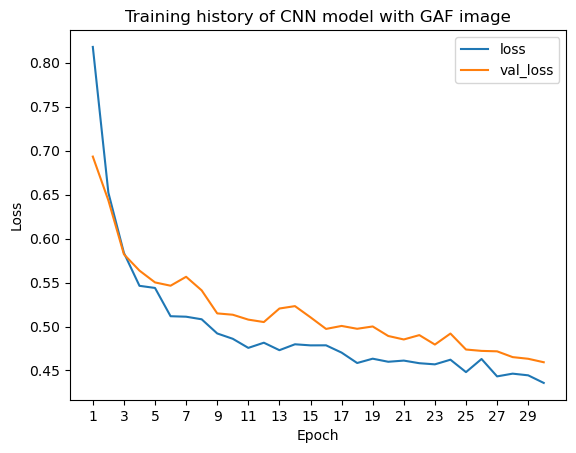

In [71]:
plt.plot(cnn_gaf_history.history['loss'], label='loss')
plt.plot(cnn_gaf_history.history['val_loss'], label='val_loss')
plt.xticks(range(0, EPOCH, 2), range(1, EPOCH+1, 2))
plt.title('Training history of CNN model with GAF image')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [72]:
cnn_gaf.save(f'{BASE}/Models/cnn_gaf.h5')

### ViT

In [73]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
gaf_train_dataloader = DataLoader(NumpyDataset(gaf_img_train, y_train_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
gaf_test_dataloader = DataLoader(NumpyDataset(gaf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [74]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_gaf = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_gaf.head = nn.Linear(vit_gaf.head.in_features, NUMCLASS)
vit_gaf = vit_gaf.to(device)

In [75]:
# Freeze all layer except added head layer
for param in vit_gaf.parameters():
    param.requires_grad = False
for param in vit_gaf.head.parameters():
    param.requires_grad = True

In [76]:
# Count parameters
total_params = sum(p.numel() for p in vit_gaf.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_gaf.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [77]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_gaf.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_gaf.train()
    running_loss = 0

    for inputs, labels in gaf_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_gaf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(gaf_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7621
Epoch 2/30, Loss: 0.5391
Epoch 3/30, Loss: 0.4497
Epoch 4/30, Loss: 0.4163
Epoch 5/30, Loss: 0.3788
Epoch 6/30, Loss: 0.3629
Epoch 7/30, Loss: 0.3576
Epoch 8/30, Loss: 0.3462
Epoch 9/30, Loss: 0.3418
Epoch 10/30, Loss: 0.3341
Epoch 11/30, Loss: 0.3296
Epoch 12/30, Loss: 0.3244
Epoch 13/30, Loss: 0.3198
Epoch 14/30, Loss: 0.3157
Epoch 15/30, Loss: 0.3113
Epoch 16/30, Loss: 0.3076
Epoch 17/30, Loss: 0.3035
Epoch 18/30, Loss: 0.2999
Epoch 19/30, Loss: 0.2962
Epoch 20/30, Loss: 0.2927
Epoch 21/30, Loss: 0.2892
Epoch 22/30, Loss: 0.2858
Epoch 23/30, Loss: 0.2824
Epoch 24/30, Loss: 0.2792
Epoch 25/30, Loss: 0.2760
Epoch 26/30, Loss: 0.2728
Epoch 27/30, Loss: 0.2698
Epoch 28/30, Loss: 0.2668
Epoch 29/30, Loss: 0.2638
Epoch 30/30, Loss: 0.2609


In [78]:
torch.save(vit_gaf.state_dict(), f'{BASE}/Models/vit_gaf.pth')

### Evaluation

#### CNN

In [79]:
tf.random.set_seed(SEED)
cnn_gaf_pred = cnn_gaf.predict(gaf_img_test)

2/2 [==============================] - 0s 8ms/step


In [80]:
cnn_gaf_pred_int = np.argmax(cnn_gaf_pred, axis=1)

In [81]:
print('Accuracy:', accuracy_score(y_test_int, cnn_gaf_pred_int))
print('Precision:', precision_score(y_test_int, cnn_gaf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_gaf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_gaf_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.39622641509433965
Recall: 0.5
F1-Score: 0.4421052631578947


c:\Users\noppa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


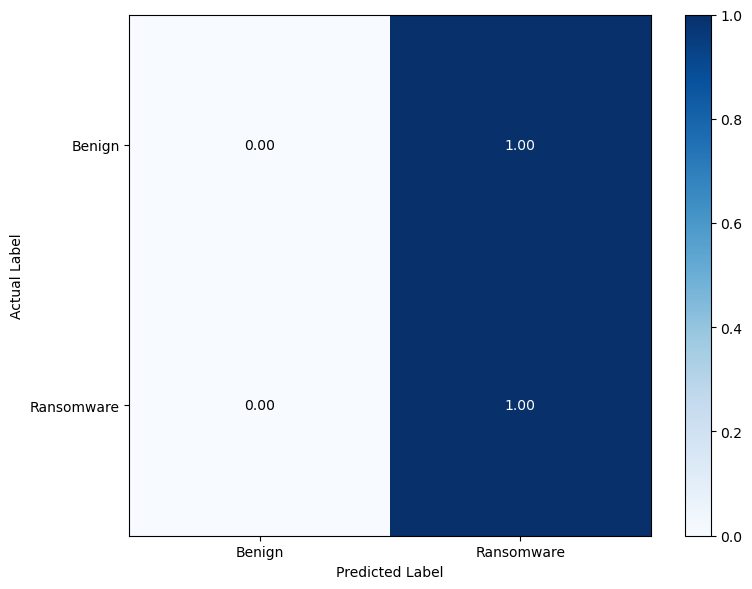

In [82]:
confusionMatrix_cnn_gaf = confusion_matrix(y_test_int, cnn_gaf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_gaf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_gaf.shape[0]):
    for j in range(confusionMatrix_cnn_gaf.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_gaf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_gaf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [83]:
vit_gaf_pred_int = evaluate(vit_gaf, gaf_test_dataloader, device)

In [84]:
print('Accuracy:', accuracy_score(y_test_int, vit_gaf_pred_int))
print('Precision:', precision_score(y_test_int, vit_gaf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_gaf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_gaf_pred_int, average='macro'))

Accuracy: 0.8490566037735849
Precision: 0.8270833333333334
Recall: 0.6699134199134199
F1-Score: 0.7055555555555555


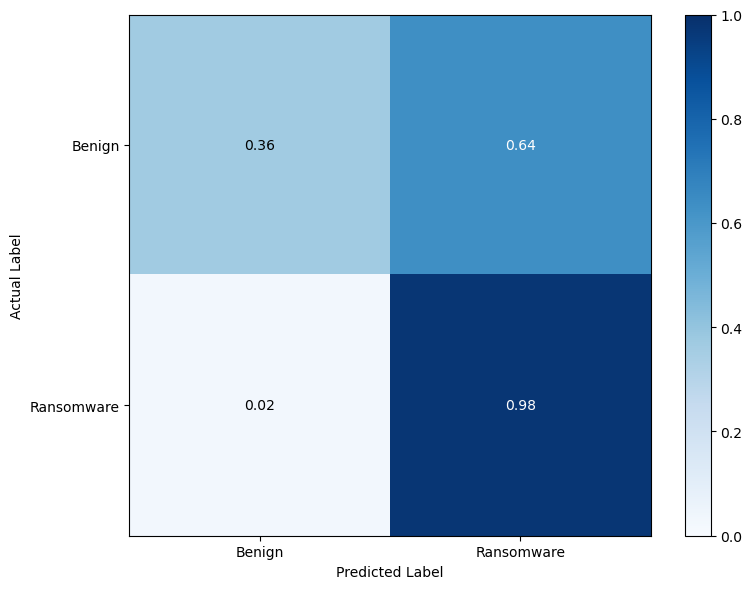

In [85]:
confusionMatrix_vit_gaf = confusion_matrix(y_test_int, vit_gaf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_gaf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_gaf.shape[0]):
    for j in range(confusionMatrix_vit_gaf.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_gaf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_gaf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

### GAF Augmentation

In [86]:
gaf0_aug = GramianAngularField(image_size=PLOTSIZE)
gaf1_aug = GramianAngularField(image_size=PLOTSIZE)
gaf2_aug = GramianAngularField(image_size=PLOTSIZE)
gaf3_aug = GramianAngularField(image_size=PLOTSIZE)
gaf4_aug = GramianAngularField(image_size=PLOTSIZE)

In [87]:
gaf_train_aug_f0 = gaf0_aug.fit_transform(data_train_aug_transposed[:, 0, :])
gaf_train_aug_f1 = gaf1_aug.fit_transform(data_train_aug_transposed[:, 1, :])
gaf_train_aug_f2 = gaf2_aug.fit_transform(data_train_aug_transposed[:, 2, :])
gaf_train_aug_f3 = gaf3_aug.fit_transform(data_train_aug_transposed[:, 3, :])
gaf_train_aug_f4 = gaf4_aug.fit_transform(data_train_aug_transposed[:, 4, :])

In [88]:
gaf_train_aug = np.empty((data_train_aug_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_aug_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_train_aug[i][j][k] = (gaf_train_aug_f0[i][j][k] + gaf_train_aug_f1[i][j][k] + gaf_train_aug_f2[i][j][k] + gaf_train_aug_f3[i][j][k] + gaf_train_aug_f4[i][j][k])/5

In [89]:
gaf_img_train_aug_tmp = []

for g in gaf_train_aug:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_train_aug_tmp.append(image_array)

In [90]:
gaf_img_train_aug = np.stack(gaf_img_train_aug_tmp, axis=0)
gaf_img_train_aug = gaf_img_train_aug/255
gaf_img_train_aug.shape

(336, 64, 64, 4)

In [91]:
gaf_test_f0 = gaf0_aug.transform(data_test_transposed[:, 0, :])
gaf_test_f1 = gaf1_aug.transform(data_test_transposed[:, 1, :])
gaf_test_f2 = gaf2_aug.transform(data_test_transposed[:, 2, :])
gaf_test_f3 = gaf3_aug.transform(data_test_transposed[:, 3, :])
gaf_test_f4 = gaf4_aug.transform(data_test_transposed[:, 4, :])

In [92]:
gaf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            gaf_test[i][j][k] = (gaf_test_f0[i][j][k] + gaf_test_f1[i][j][k] + gaf_test_f2[i][j][k] + gaf_test_f3[i][j][k] + gaf_test_f4[i][j][k])/5

In [93]:
gaf_img_test_tmp = []

for g in gaf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    gaf_img_test_tmp.append(image_array)

In [94]:
gaf_img_test = np.stack(gaf_img_test_tmp, axis=0)
gaf_img_test = gaf_img_test/255
gaf_img_test.shape

(53, 64, 64, 4)

#### CNN with SMOTE

In [95]:
tf.random.set_seed(SEED)
cnn_gaf_aug = Sequential(name='CNN_GAF_aug')
cnn_gaf_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(gaf_img_train_aug.shape[1], gaf_img_train_aug.shape[2], gaf_img_train_aug.shape[3])))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Dropout(0.2))
cnn_gaf_aug.add(Conv2D(16, (3, 3), activation='relu'))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Dropout(0.2))
cnn_gaf_aug.add(Conv2D(8, (3, 3), activation='relu'))
cnn_gaf_aug.add(MaxPooling2D((2, 2)))
cnn_gaf_aug.add(Flatten())
cnn_gaf_aug.add(Dense(8, activation='relu'))
cnn_gaf_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_gaf_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
cnn_gaf_aug.summary()

Model: "CNN_GAF_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 16)        

In [97]:
tf.random.set_seed(SEED)
cnn_gaf_aug_history = cnn_gaf_aug.fit(gaf_img_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
9/9 [==============================] - 2s 162ms/step - loss: 0.7059 - accuracy: 0.5037 - val_loss: 0.6940 - val_accuracy: 0.4706
Epoch 2/30
9/9 [==============================] - 1s 125ms/step - loss: 0.6938 - accuracy: 0.5075 - val_loss: 0.6937 - val_accuracy: 0.4706
Epoch 3/30
9/9 [==============================] - 1s 129ms/step - loss: 0.6941 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5294
Epoch 4/30
9/9 [==============================] - 1s 138ms/step - loss: 0.6927 - accuracy: 0.5112 - val_loss: 0.6923 - val_accuracy: 0.5294
Epoch 5/30
9/9 [==============================] - 1s 151ms/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6922 - val_accuracy: 0.6912
Epoch 6/30
9/9 [==============================] - 1s 153ms/step - loss: 0.6930 - accuracy: 0.5261 - val_loss: 0.6915 - val_accuracy: 0.6765
Epoch 7/30
9/9 [==============================] - 1s 150ms/step - loss: 0.6917 - accuracy: 0.5522 - val_loss: 0.6904 - val_accuracy: 0.6029
Epoch 8/30
9/9 [====

<function matplotlib.pyplot.show(close=None, block=None)>

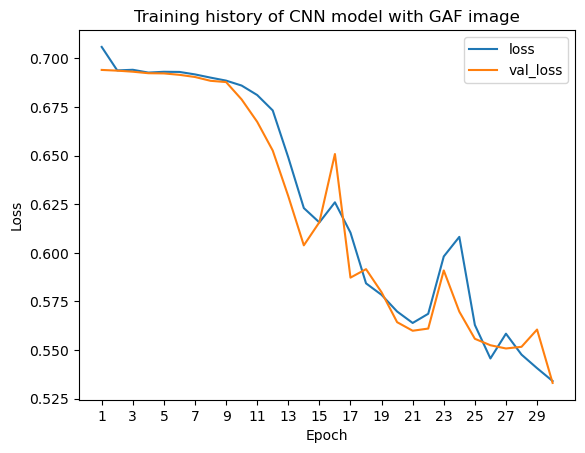

In [98]:
plt.plot(cnn_gaf_aug_history.history['loss'], label='loss')
plt.plot(cnn_gaf_aug_history.history['val_loss'], label='val_loss')
plt.xticks(range(0, EPOCH, 2), range(1, EPOCH+1, 2))
plt.title('Training history of CNN model with GAF image')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [99]:
cnn_gaf_aug.save(f'{BASE}/Models/cnn_gaf_aug.h5')

#### ViT with SMOTE

In [100]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
gaf_train_aug_dataloader = DataLoader(NumpyDataset(gaf_img_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
gaf_test_dataloader = DataLoader(NumpyDataset(gaf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [101]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_gaf_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_gaf_aug.head = nn.Linear(vit_gaf_aug.head.in_features, NUMCLASS)
vit_gaf_aug = vit_gaf_aug.to(device)

In [102]:
for param in vit_gaf_aug.parameters():
    param.requires_grad = False
for param in vit_gaf_aug.head.parameters():
    param.requires_grad = True

In [103]:
total_params = sum(p.numel() for p in vit_gaf_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_gaf_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [104]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_gaf_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_gaf_aug.train()
    running_loss = 0

    for inputs, labels in gaf_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_gaf_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(gaf_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7673
Epoch 2/30, Loss: 0.5813
Epoch 3/30, Loss: 0.5560
Epoch 4/30, Loss: 0.5199
Epoch 5/30, Loss: 0.4899
Epoch 6/30, Loss: 0.4761
Epoch 7/30, Loss: 0.4657
Epoch 8/30, Loss: 0.4560
Epoch 9/30, Loss: 0.4458
Epoch 10/30, Loss: 0.4356
Epoch 11/30, Loss: 0.4260
Epoch 12/30, Loss: 0.4172
Epoch 13/30, Loss: 0.4091
Epoch 14/30, Loss: 0.4015
Epoch 15/30, Loss: 0.3943
Epoch 16/30, Loss: 0.3874
Epoch 17/30, Loss: 0.3806
Epoch 18/30, Loss: 0.3741
Epoch 19/30, Loss: 0.3679
Epoch 20/30, Loss: 0.3618
Epoch 21/30, Loss: 0.3560
Epoch 22/30, Loss: 0.3504
Epoch 23/30, Loss: 0.3450
Epoch 24/30, Loss: 0.3398
Epoch 25/30, Loss: 0.3348
Epoch 26/30, Loss: 0.3299
Epoch 27/30, Loss: 0.3252
Epoch 28/30, Loss: 0.3206
Epoch 29/30, Loss: 0.3162
Epoch 30/30, Loss: 0.3120


In [105]:
torch.save(vit_gaf_aug.state_dict(), f'{BASE}/Models/vit_gaf_aug.pth')

#### Evaluation

##### CNN

In [106]:
tf.random.set_seed(SEED)
cnn_gaf_aug_pred = cnn_gaf_aug.predict(gaf_img_test)

2/2 [==============================] - 0s 0s/step


In [107]:
cnn_gaf_aug_pred_int = np.argmax(cnn_gaf_aug_pred, axis=1)

In [108]:
print('Accuracy:', accuracy_score(y_test_int, cnn_gaf_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_gaf_aug_pred_int, average='macro'))

Accuracy: 0.660377358490566
Precision: 0.6442857142857144
Recall: 0.7186147186147187
F1-Score: 0.6214285714285714


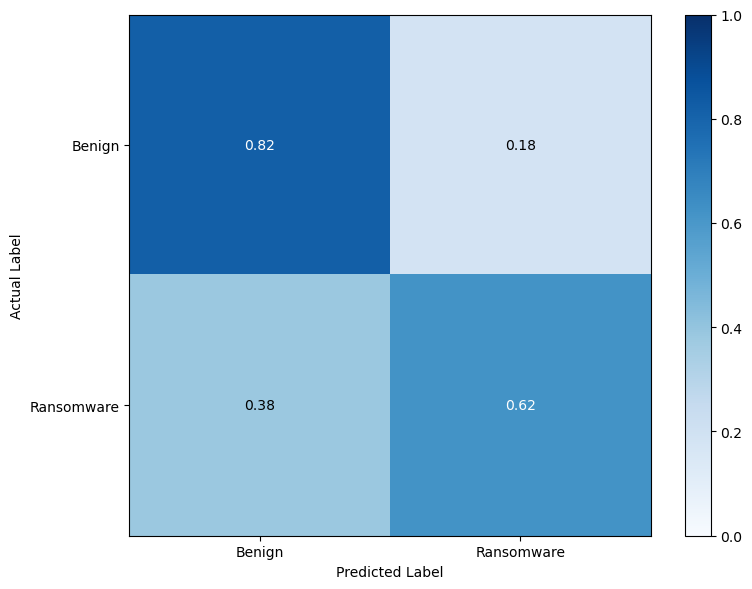

In [109]:
confusionMatrix_cnn_gaf_aug = confusion_matrix(y_test_int, cnn_gaf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_gaf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_gaf_aug.shape[0]):
    for j in range(confusionMatrix_cnn_gaf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_gaf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_gaf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

##### ViT

In [110]:
vit_gaf_aug_pred_int = evaluate(vit_gaf_aug, gaf_test_dataloader, device)

In [111]:
print('Accuracy:', accuracy_score(y_test_int, vit_gaf_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_gaf_aug_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.7094594594594594
Recall: 0.7683982683982684
F1-Score: 0.7266760431317394


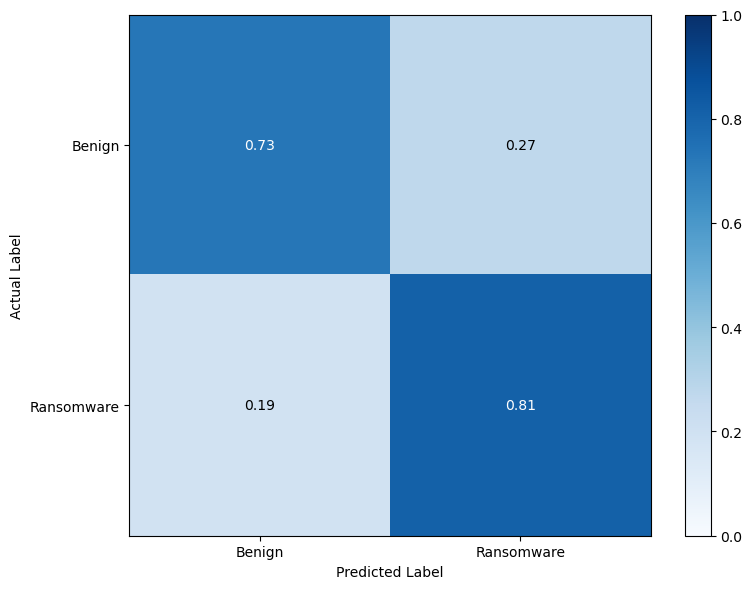

In [112]:
confusionMatrix_vit_gaf_aug = confusion_matrix(y_test_int, vit_gaf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_gaf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_gaf_aug.shape[0]):
    for j in range(confusionMatrix_vit_gaf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_gaf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_gaf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

## Markov Transition Field

In [113]:
mtf0 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [114]:
mtf_train_f0 = mtf0.fit_transform(data_train_transposed[:, 0, :])
mtf_train_f1 = mtf1.fit_transform(data_train_transposed[:, 1, :])
mtf_train_f2 = mtf2.fit_transform(data_train_transposed[:, 2, :])
mtf_train_f3 = mtf3.fit_transform(data_train_transposed[:, 3, :])
mtf_train_f4 = mtf4.fit_transform(data_train_transposed[:, 4, :])

In [115]:
mtf_train = np.empty((data_train_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train[i][j][k] = (mtf_train_f0[i][j][k] + mtf_train_f1[i][j][k] + mtf_train_f2[i][j][k] + mtf_train_f3[i][j][k] + mtf_train_f4[i][j][k])/5

In [116]:
mtf_img_train_tmp = []

for g in mtf_train:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_tmp.append(image_array)

In [117]:
mtf_img_train = np.stack(mtf_img_train_tmp, axis=0)
mtf_img_train = mtf_img_train/255
mtf_img_train.shape

(208, 64, 64, 4)

In [118]:
mtf_test_f0 = mtf0.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4.transform(data_test_transposed[:, 4, :])

In [119]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [120]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [121]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(53, 64, 64, 4)

### CNN

In [122]:
tf.random.set_seed(SEED)
cnn_mtf = Sequential(name='CNN_MTF')
cnn_mtf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train.shape[1], mtf_img_train.shape[2], mtf_img_train.shape[3])))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf.add(Flatten())
cnn_mtf.add(Dense(8, activation='relu'))
cnn_mtf.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
cnn_mtf.summary()

Model: "CNN_MTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 16)        0   

In [124]:
tf.random.set_seed(SEED)
cnn_mtf_history = cnn_mtf.fit(mtf_img_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
6/6 [==============================] - 2s 147ms/step - loss: 0.5464 - accuracy: 0.8012 - val_loss: 0.5261 - val_accuracy: 0.7857
Epoch 2/30
6/6 [==============================] - 1s 104ms/step - loss: 0.5363 - accuracy: 0.8133 - val_loss: 0.5167 - val_accuracy: 0.7857
Epoch 3/30
6/6 [==============================] - 1s 113ms/step - loss: 0.4872 - accuracy: 0.8133 - val_loss: 0.5489 - val_accuracy: 0.7857
Epoch 4/30
6/6 [==============================] - 1s 122ms/step - loss: 0.4934 - accuracy: 0.8133 - val_loss: 0.5340 - val_accuracy: 0.7857
Epoch 5/30
6/6 [==============================] - 1s 106ms/step - loss: 0.4953 - accuracy: 0.8133 - val_loss: 0.5185 - val_accuracy: 0.7857
Epoch 6/30
6/6 [==============================] - 1s 141ms/step - loss: 0.4886 - accuracy: 0.8133 - val_loss: 0.5200 - val_accuracy: 0.7857
Epoch 7/30
6/6 [==============================] - 1s 110ms/step - loss: 0.4899 - accuracy: 0.8133 - val_loss: 0.5554 - val_accuracy: 0.7857
Epoch 8/30
6/6 [====

In [125]:
cnn_mtf.save(f'{BASE}/Models/cnn_mtf.h5')

### ViT

In [126]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_dataloader = DataLoader(NumpyDataset(mtf_img_train, y_train_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [127]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf.head = nn.Linear(vit_mtf.head.in_features, NUMCLASS)
vit_mtf = vit_mtf.to(device)

In [128]:
for param in vit_mtf.parameters():
    param.requires_grad = False
for param in vit_mtf.head.parameters():
    param.requires_grad = True

In [129]:
total_params = sum(p.numel() for p in vit_mtf.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [130]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf.train()
    running_loss = 0

    for inputs, labels in mtf_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7551
Epoch 2/30, Loss: 0.5453
Epoch 3/30, Loss: 0.4893
Epoch 4/30, Loss: 0.4460
Epoch 5/30, Loss: 0.4093
Epoch 6/30, Loss: 0.3950
Epoch 7/30, Loss: 0.3811
Epoch 8/30, Loss: 0.3696
Epoch 9/30, Loss: 0.3620
Epoch 10/30, Loss: 0.3531
Epoch 11/30, Loss: 0.3476
Epoch 12/30, Loss: 0.3411
Epoch 13/30, Loss: 0.3359
Epoch 14/30, Loss: 0.3309
Epoch 15/30, Loss: 0.3261
Epoch 16/30, Loss: 0.3220
Epoch 17/30, Loss: 0.3179
Epoch 18/30, Loss: 0.3142
Epoch 19/30, Loss: 0.3106
Epoch 20/30, Loss: 0.3073
Epoch 21/30, Loss: 0.3041
Epoch 22/30, Loss: 0.3011
Epoch 23/30, Loss: 0.2983
Epoch 24/30, Loss: 0.2955
Epoch 25/30, Loss: 0.2928
Epoch 26/30, Loss: 0.2903
Epoch 27/30, Loss: 0.2878
Epoch 28/30, Loss: 0.2854
Epoch 29/30, Loss: 0.2831
Epoch 30/30, Loss: 0.2808


In [131]:
torch.save(vit_mtf.state_dict(), f'{BASE}/Models/vit_mtf.pth')

### Evaluation

#### CNN

In [132]:
tf.random.set_seed(SEED)
cnn_mtf_pred = cnn_mtf.predict(mtf_img_test)

2/2 [==============================] - 0s 4ms/step


In [133]:
cnn_mtf_pred_int = np.argmax(cnn_mtf_pred, axis=1)

In [134]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.39622641509433965
Recall: 0.5
F1-Score: 0.4421052631578947


c:\Users\noppa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


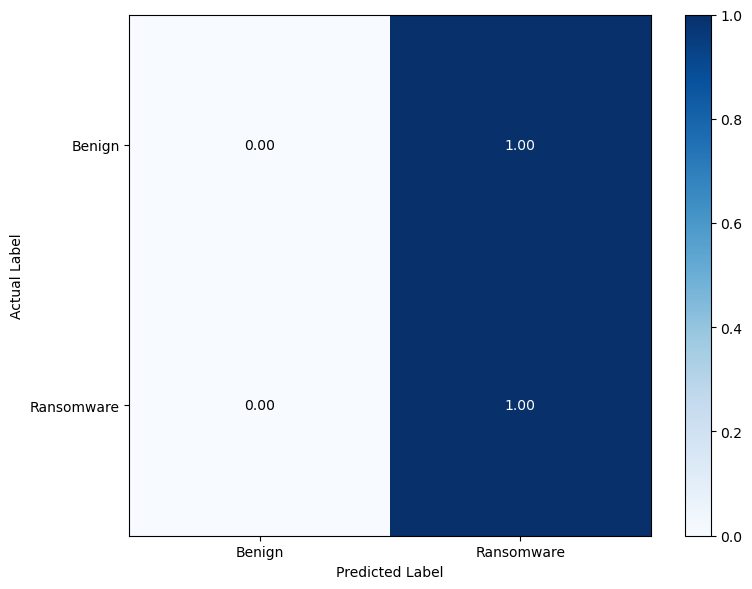

In [135]:
confusionMatrix_cnn_mtf = confusion_matrix(y_test_int, cnn_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf.shape[0]):
    for j in range(confusionMatrix_cnn_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [136]:
vit_mtf_pred_int = evaluate(vit_mtf, mtf_test_dataloader, device)

In [137]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.6581632653061225
Recall: 0.5670995670995671
F1-Score: 0.5728937728937729


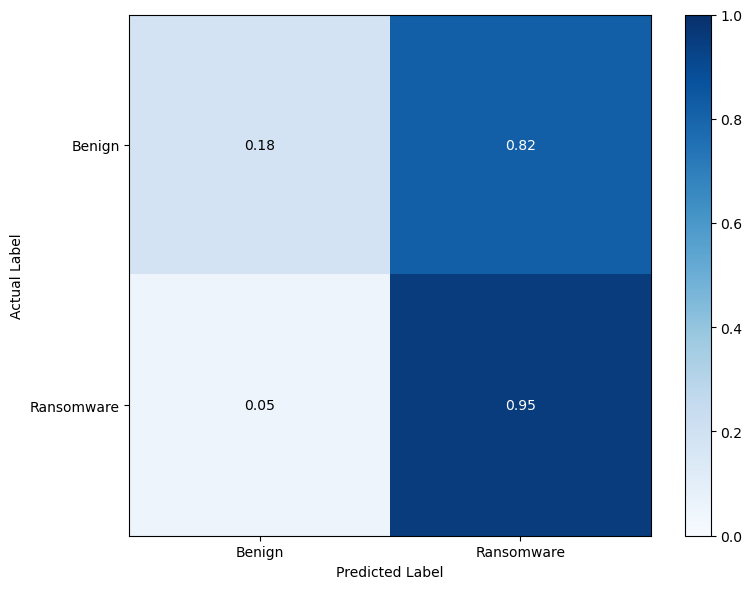

In [138]:
confusionMatrix_vit_mtf = confusion_matrix(y_test_int, vit_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf.shape[0]):
    for j in range(confusionMatrix_vit_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

### MTF Augmentation

In [139]:
mtf0_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [140]:
mtf_train_aug_f0 = mtf0_aug.fit_transform(data_train_aug_transposed[:, 0, :])
mtf_train_aug_f1 = mtf1_aug.fit_transform(data_train_aug_transposed[:, 1, :])
mtf_train_aug_f2 = mtf2_aug.fit_transform(data_train_aug_transposed[:, 2, :])
mtf_train_aug_f3 = mtf3_aug.fit_transform(data_train_aug_transposed[:, 3, :])
mtf_train_aug_f4 = mtf4_aug.fit_transform(data_train_aug_transposed[:, 4, :])

In [141]:
mtf_train_aug = np.empty((data_train_aug_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_aug_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train_aug[i][j][k] = (mtf_train_aug_f0[i][j][k] + mtf_train_aug_f1[i][j][k] + mtf_train_aug_f2[i][j][k] + mtf_train_aug_f3[i][j][k] + mtf_train_aug_f4[i][j][k])/5

In [142]:
mtf_img_train_aug_tmp = []

for g in mtf_train_aug:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_aug_tmp.append(image_array)

In [143]:
mtf_img_train_aug = np.stack(mtf_img_train_aug_tmp, axis=0)
mtf_img_train_aug = mtf_img_train_aug/255
mtf_img_train_aug.shape

(336, 64, 64, 4)

In [144]:
mtf_test_f0 = mtf0_aug.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1_aug.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2_aug.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3_aug.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4_aug.transform(data_test_transposed[:, 4, :])

In [145]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [146]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [147]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(53, 64, 64, 4)

#### CNN with SMOTE

In [148]:
tf.random.set_seed(SEED)
cnn_mtf_aug = Sequential(name='CNN_MTF_aug')
cnn_mtf_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train_aug.shape[1], mtf_img_train_aug.shape[2], mtf_img_train_aug.shape[3])))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf_aug.add(Flatten())
cnn_mtf_aug.add(Dense(8, activation='relu'))
cnn_mtf_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [149]:
cnn_mtf_aug.summary()

Model: "CNN_MTF_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 16)        

In [150]:
tf.random.set_seed(SEED)
cnn_mtf_aug_history = cnn_mtf_aug.fit(mtf_img_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
9/9 [==============================] - 2s 139ms/step - loss: 0.6980 - accuracy: 0.4627 - val_loss: 0.6928 - val_accuracy: 0.5441
Epoch 2/30
9/9 [==============================] - 1s 138ms/step - loss: 0.6932 - accuracy: 0.5112 - val_loss: 0.6932 - val_accuracy: 0.4559
Epoch 3/30
9/9 [==============================] - 1s 133ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6917 - val_accuracy: 0.5882
Epoch 4/30
9/9 [==============================] - 1s 146ms/step - loss: 0.6927 - accuracy: 0.5112 - val_loss: 0.6934 - val_accuracy: 0.4559
Epoch 5/30
9/9 [==============================] - 1s 132ms/step - loss: 0.6934 - accuracy: 0.5075 - val_loss: 0.6915 - val_accuracy: 0.5147
Epoch 6/30
9/9 [==============================] - 1s 127ms/step - loss: 0.6903 - accuracy: 0.5149 - val_loss: 0.6917 - val_accuracy: 0.5441
Epoch 7/30
9/9 [==============================] - 1s 135ms/step - loss: 0.6895 - accuracy: 0.5261 - val_loss: 0.6932 - val_accuracy: 0.5147
Epoch 8/30
9/9 [====

In [151]:
cnn_mtf_aug.save(f'{BASE}/Models/cnn_mtf_aug.h5')

#### ViT with SMOTE

In [152]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_aug_dataloader = DataLoader(NumpyDataset(mtf_img_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [153]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf_aug.head = nn.Linear(vit_mtf_aug.head.in_features, NUMCLASS)
vit_mtf_aug = vit_mtf_aug.to(device)

In [154]:
for param in vit_mtf_aug.parameters():
    param.requires_grad = False
for param in vit_mtf_aug.head.parameters():
    param.requires_grad = True

In [155]:
total_params = sum(p.numel() for p in vit_mtf_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [156]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf_aug.train()
    running_loss = 0

    for inputs, labels in mtf_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7719
Epoch 2/30, Loss: 0.6548
Epoch 3/30, Loss: 0.6694
Epoch 4/30, Loss: 0.6259
Epoch 5/30, Loss: 0.5738
Epoch 6/30, Loss: 0.5618
Epoch 7/30, Loss: 0.5667
Epoch 8/30, Loss: 0.5641
Epoch 9/30, Loss: 0.5533
Epoch 10/30, Loss: 0.5434
Epoch 11/30, Loss: 0.5373
Epoch 12/30, Loss: 0.5327
Epoch 13/30, Loss: 0.5278
Epoch 14/30, Loss: 0.5227
Epoch 15/30, Loss: 0.5177
Epoch 16/30, Loss: 0.5132
Epoch 17/30, Loss: 0.5090
Epoch 18/30, Loss: 0.5050
Epoch 19/30, Loss: 0.5011
Epoch 20/30, Loss: 0.4974
Epoch 21/30, Loss: 0.4939
Epoch 22/30, Loss: 0.4904
Epoch 23/30, Loss: 0.4872
Epoch 24/30, Loss: 0.4840
Epoch 25/30, Loss: 0.4809
Epoch 26/30, Loss: 0.4779
Epoch 27/30, Loss: 0.4751
Epoch 28/30, Loss: 0.4723
Epoch 29/30, Loss: 0.4696
Epoch 30/30, Loss: 0.4669


In [157]:
torch.save(vit_mtf_aug.state_dict(), f'{BASE}/Models/vit_mtf_aug.pth')

#### Evaluation

##### CNN

In [158]:
tf.random.set_seed(SEED)
cnn_mtf_aug_pred = cnn_mtf_aug.predict(mtf_img_test)

2/2 [==============================] - 0s 31ms/step


In [159]:
cnn_mtf_aug_pred_int = np.argmax(cnn_mtf_aug_pred, axis=1)

In [160]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))

Accuracy: 0.5283018867924528
Precision: 0.6207430340557275
Recall: 0.6688311688311688
F1-Score: 0.517304189435337


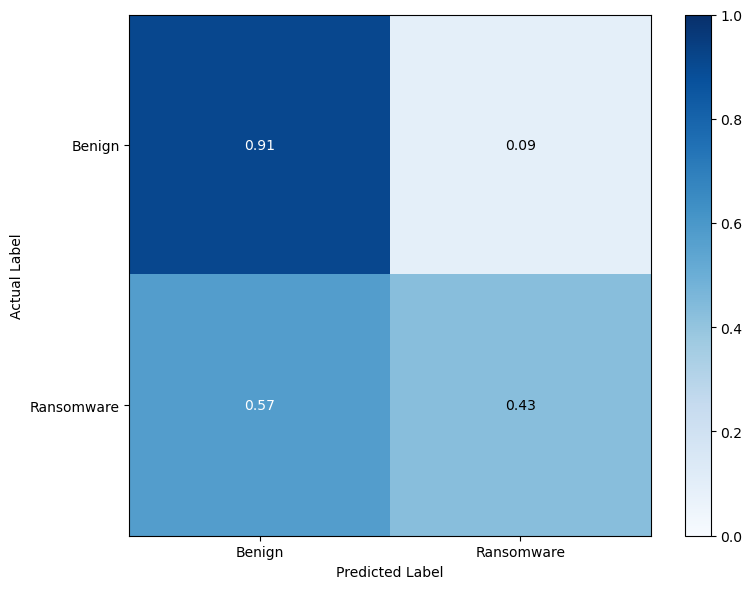

In [161]:
confusionMatrix_cnn_mtf_aug = confusion_matrix(y_test_int, cnn_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf_aug.shape[0]):
    for j in range(confusionMatrix_cnn_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

##### ViT

In [162]:
vit_mtf_aug_pred_int = evaluate(vit_mtf_aug, mtf_test_dataloader, device)

In [163]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))

Accuracy: 0.6226415094339622
Precision: 0.5855072463768116
Recall: 0.6277056277056277
F1-Score: 0.5669934640522876


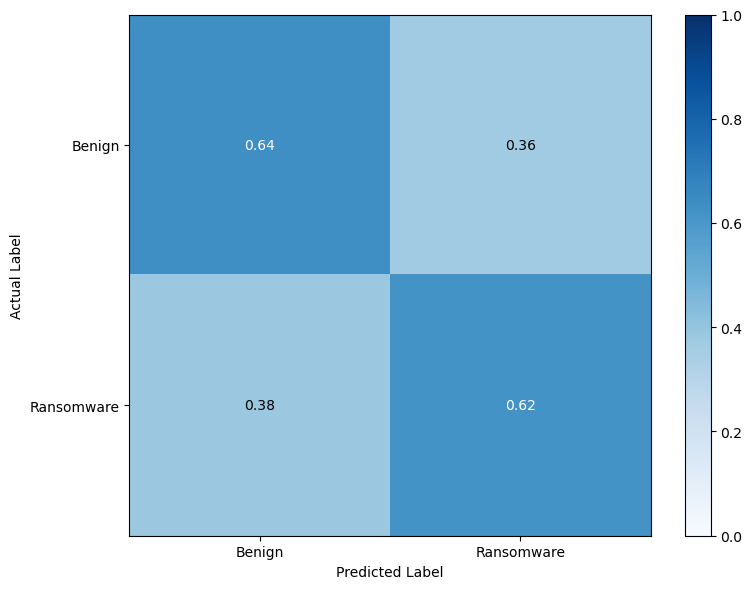

In [164]:
confusionMatrix_vit_mtf_aug = confusion_matrix(y_test_int, vit_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf_aug.shape[0]):
    for j in range(confusionMatrix_vit_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

## Correlation Matrix

In [165]:
contour_train_tmp = []

for i in range(data_train_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_train_transposed[i, 0, :],
        'Feature2': data_train_transposed[i, 1, :],
        'Feature3': data_train_transposed[i, 2, :],
        'Feature4': data_train_transposed[i, 3, :],
        'Feature5': data_train_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_train_tmp.append(image_array)

In [166]:
contour_train = np.stack(contour_train_tmp, axis=0)
contour_train = contour_train/255
contour_train.shape

(208, 64, 64, 4)

In [167]:
contour_train_aug_tmp = []

for i in range(data_train_aug_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_train_aug_transposed[i, 0, :],
        'Feature2': data_train_aug_transposed[i, 1, :],
        'Feature3': data_train_aug_transposed[i, 2, :],
        'Feature4': data_train_aug_transposed[i, 3, :],
        'Feature5': data_train_aug_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_train_aug_tmp.append(image_array)

In [168]:
contour_train_aug = np.stack(contour_train_aug_tmp, axis=0)
contour_train_aug = contour_train_aug/255
contour_train_aug.shape

(336, 64, 64, 4)

In [169]:
contour_test_tmp = []

for i in range(data_test_transposed.shape[0]):
    df = pd.DataFrame({
        'Feature1': data_test_transposed[i, 0, :],
        'Feature2': data_test_transposed[i, 1, :],
        'Feature3': data_test_transposed[i, 2, :],
        'Feature4': data_test_transposed[i, 3, :],
        'Feature5': data_test_transposed[i, 4, :]
        })
    cor = df.corr()

    X, Y = np.meshgrid(range(cor.shape[1]), range(cor.shape[0]))
    Z = cor.values

    plt.figure(figsize=(6, 6))
    plt.contourf(X, Y, Z)
    plt.contour(X, Y, Z, colors='black')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    contour_test_tmp.append(image_array)

In [170]:
contour_test = np.stack(contour_test_tmp, axis=0)
contour_test = contour_test/255
contour_test.shape

(53, 64, 64, 4)

### CNN

In [171]:
tf.random.set_seed(SEED)
cnn_contour = Sequential(name='CNN_Contour')
cnn_contour.add(Conv2D(32, (3, 3), activation='relu', input_shape=(contour_train.shape[1], contour_train.shape[2], contour_train.shape[3])))
cnn_contour.add(MaxPooling2D((2, 2)))
cnn_contour.add(Dropout(0.2))
cnn_contour.add (Conv2D(16, (3, 3), activation='relu'))
cnn_contour.add(MaxPooling2D((2, 2)))
cnn_contour.add(Dropout(0.2))
cnn_contour.add (Conv2D(8, (3, 3), activation='relu'))
cnn_contour.add(Flatten())
cnn_contour.add(Dense(8, activation='relu'))
cnn_contour.add(Dense(NUMCLASS, activation='softmax'))

cnn_contour.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [172]:
cnn_contour.summary()

Model: "CNN_Contour"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 16)        

In [173]:
tf.random.set_seed(SEED)
cnn_contour_history = cnn_contour.fit(contour_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
6/6 [==============================] - 2s 170ms/step - loss: 0.5470 - accuracy: 0.7711 - val_loss: 0.5352 - val_accuracy: 0.7857
Epoch 2/30
6/6 [==============================] - 1s 132ms/step - loss: 0.5417 - accuracy: 0.8133 - val_loss: 0.5202 - val_accuracy: 0.7857
Epoch 3/30
6/6 [==============================] - 1s 97ms/step - loss: 0.4851 - accuracy: 0.8133 - val_loss: 0.5483 - val_accuracy: 0.7857
Epoch 4/30
6/6 [==============================] - 1s 127ms/step - loss: 0.5085 - accuracy: 0.8133 - val_loss: 0.5423 - val_accuracy: 0.7857
Epoch 5/30
6/6 [==============================] - 1s 106ms/step - loss: 0.4888 - accuracy: 0.8133 - val_loss: 0.5189 - val_accuracy: 0.7857
Epoch 6/30
6/6 [==============================] - 1s 91ms/step - loss: 0.4869 - accuracy: 0.8133 - val_loss: 0.5194 - val_accuracy: 0.7857
Epoch 7/30
6/6 [==============================] - 1s 94ms/step - loss: 0.4830 - accuracy: 0.8133 - val_loss: 0.5518 - val_accuracy: 0.7857
Epoch 8/30
6/6 [=======

In [174]:
cnn_contour.save(f'{BASE}/Models/cnn_contour.h5')

### CNN with SMOTE

In [175]:
tf.random.set_seed(SEED)
cnn_contour_aug = Sequential(name='CNN_Contour_aug')
cnn_contour_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(contour_train_aug.shape[1], contour_train_aug.shape[2], contour_train_aug.shape[3])))
cnn_contour_aug.add(MaxPooling2D((2, 2)))
cnn_contour_aug.add(Dropout(0.2))
cnn_contour_aug.add (Conv2D(16, (3, 3), activation='relu'))
cnn_contour_aug.add(MaxPooling2D((2, 2)))
cnn_contour_aug.add(Dropout(0.2))
cnn_contour_aug.add (Conv2D(8, (3, 3), activation='relu'))
cnn_contour_aug.add(Flatten())
cnn_contour_aug.add(Dense(8, activation='relu'))
cnn_contour_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_contour_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [176]:
cnn_contour_aug.summary()

Model: "CNN_Contour_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        1184      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 16)    

In [177]:
tf.random.set_seed(SEED)
cnn_contour_aug_history = cnn_contour_aug.fit(contour_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
9/9 [==============================] - 4s 163ms/step - loss: 0.7088 - accuracy: 0.4888 - val_loss: 0.6878 - val_accuracy: 0.5294
Epoch 2/30
9/9 [==============================] - 1s 123ms/step - loss: 0.6970 - accuracy: 0.4701 - val_loss: 0.6958 - val_accuracy: 0.4706
Epoch 3/30
9/9 [==============================] - 1s 126ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6897 - val_accuracy: 0.5441
Epoch 4/30
9/9 [==============================] - 1s 133ms/step - loss: 0.6892 - accuracy: 0.5709 - val_loss: 0.6870 - val_accuracy: 0.5441
Epoch 5/30
9/9 [==============================] - 1s 143ms/step - loss: 0.6896 - accuracy: 0.5410 - val_loss: 0.6817 - val_accuracy: 0.5294
Epoch 6/30
9/9 [==============================] - 1s 136ms/step - loss: 0.6866 - accuracy: 0.5410 - val_loss: 0.6799 - val_accuracy: 0.6765
Epoch 7/30
9/9 [==============================] - 1s 154ms/step - loss: 0.6824 - accuracy: 0.6045 - val_loss: 0.6750 - val_accuracy: 0.7059
Epoch 8/30
9/9 [====

In [178]:
cnn_contour_aug.save(f'{BASE}/Models/cnn_contour_aug.h5')

### ViT

In [179]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
contour_train_dataloader = DataLoader(NumpyDataset(contour_train, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
contour_test_dataloader = DataLoader(NumpyDataset(contour_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [180]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_contour = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_contour.head = nn.Linear(vit_contour.head.in_features, NUMCLASS)
vit_contour = vit_contour.to(device)

In [181]:
for param in vit_contour.parameters():
    param.requires_grad = False
for param in vit_contour.head.parameters():
    param.requires_grad = True

In [182]:
total_params = sum(p.numel() for p in vit_contour.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_contour.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [183]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_contour.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_contour.train()
    running_loss = 0

    for inputs, labels in contour_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_contour(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(contour_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.8789
Epoch 2/30, Loss: 0.8005
Epoch 3/30, Loss: 0.6918
Epoch 4/30, Loss: 0.6846
Epoch 5/30, Loss: 0.6583
Epoch 6/30, Loss: 0.6434
Epoch 7/30, Loss: 0.6360
Epoch 8/30, Loss: 0.6210
Epoch 9/30, Loss: 0.6165
Epoch 10/30, Loss: 0.6066
Epoch 11/30, Loss: 0.5987
Epoch 12/30, Loss: 0.5930
Epoch 13/30, Loss: 0.5857
Epoch 14/30, Loss: 0.5799
Epoch 15/30, Loss: 0.5745
Epoch 16/30, Loss: 0.5688
Epoch 17/30, Loss: 0.5636
Epoch 18/30, Loss: 0.5588
Epoch 19/30, Loss: 0.5540
Epoch 20/30, Loss: 0.5494
Epoch 21/30, Loss: 0.5451
Epoch 22/30, Loss: 0.5408
Epoch 23/30, Loss: 0.5368
Epoch 24/30, Loss: 0.5329
Epoch 25/30, Loss: 0.5291
Epoch 26/30, Loss: 0.5254
Epoch 27/30, Loss: 0.5218
Epoch 28/30, Loss: 0.5184
Epoch 29/30, Loss: 0.5150
Epoch 30/30, Loss: 0.5118


In [184]:
torch.save(vit_contour.state_dict(), f'{BASE}/Models/vit_contour.pth')

### ViT with SMOTE

In [185]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
contour_train_aug_dataloader = DataLoader(NumpyDataset(contour_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [186]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_contour_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_contour_aug.head = nn.Linear(vit_contour_aug.head.in_features, NUMCLASS)
vit_contour_aug = vit_contour_aug.to(device)

In [187]:
for param in vit_contour_aug.parameters():
    param.requires_grad = False
for param in vit_contour_aug.head.parameters():
    param.requires_grad = True

In [188]:
total_params = sum(p.numel() for p in vit_contour_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_contour_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [189]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_contour_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_contour_aug.train()
    running_loss = 0

    for inputs, labels in contour_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_contour_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(contour_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.8084
Epoch 2/30, Loss: 0.6281
Epoch 3/30, Loss: 0.5836
Epoch 4/30, Loss: 0.5552
Epoch 5/30, Loss: 0.5310
Epoch 6/30, Loss: 0.5090
Epoch 7/30, Loss: 0.4895
Epoch 8/30, Loss: 0.4722
Epoch 9/30, Loss: 0.4566
Epoch 10/30, Loss: 0.4422
Epoch 11/30, Loss: 0.4291
Epoch 12/30, Loss: 0.4172
Epoch 13/30, Loss: 0.4061
Epoch 14/30, Loss: 0.3959
Epoch 15/30, Loss: 0.3865
Epoch 16/30, Loss: 0.3777
Epoch 17/30, Loss: 0.3694
Epoch 18/30, Loss: 0.3617
Epoch 19/30, Loss: 0.3544
Epoch 20/30, Loss: 0.3475
Epoch 21/30, Loss: 0.3411
Epoch 22/30, Loss: 0.3349
Epoch 23/30, Loss: 0.3291
Epoch 24/30, Loss: 0.3235
Epoch 25/30, Loss: 0.3182
Epoch 26/30, Loss: 0.3131
Epoch 27/30, Loss: 0.3082
Epoch 28/30, Loss: 0.3034
Epoch 29/30, Loss: 0.2988
Epoch 30/30, Loss: 0.2943


In [190]:
torch.save(vit_contour_aug.state_dict(), f'{BASE}/Models/vit_contour_aug.pth')

### Evaluation

#### CNN

In [191]:
tf.random.set_seed(SEED)
cnn_contour_pred = cnn_contour.predict(contour_test)

2/2 [==============================] - 1s 43ms/step


In [192]:
cnn_contour_pred_int = np.argmax(cnn_contour_pred, axis=1)

In [193]:
print('Accuracy:', accuracy_score(y_test_int, cnn_contour_pred_int))
print('Precision:', precision_score(y_test_int, cnn_contour_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_contour_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_contour_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.39622641509433965
Recall: 0.5
F1-Score: 0.4421052631578947


c:\Users\noppa\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


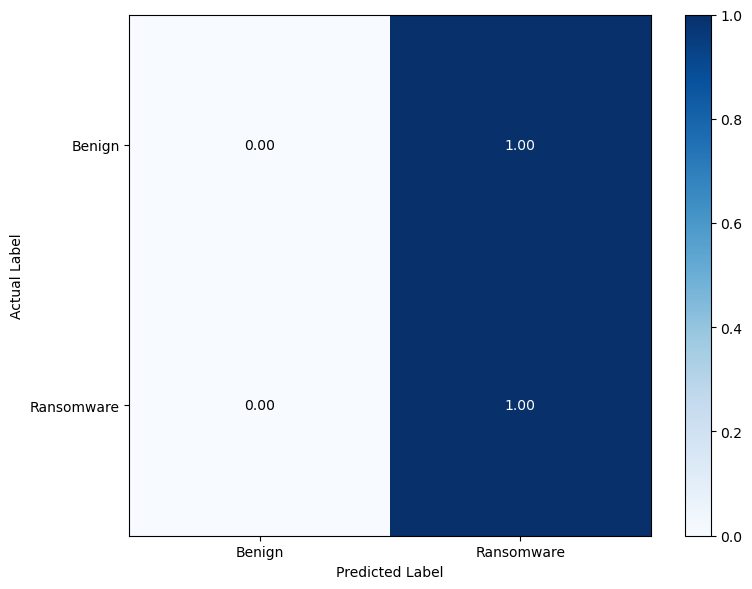

In [194]:
confusionMatrix_cnn_contour = confusion_matrix(y_test_int, cnn_contour_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_contour, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_contour.shape[0]):
    for j in range(confusionMatrix_cnn_contour.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_contour[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_contour[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### CNN with SMOTE

In [195]:
tf.random.set_seed(SEED)
cnn_contour_aug_pred = cnn_contour_aug.predict(contour_test)

2/2 [==============================] - 0s 0s/step


In [196]:
cnn_contour_aug_pred_int = np.argmax(cnn_contour_aug_pred, axis=1)

In [197]:
print('Accuracy:', accuracy_score(y_test_int, cnn_contour_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_contour_aug_pred_int, average='macro'))

Accuracy: 0.7735849056603774
Precision: 0.6426767676767677
Recall: 0.6222943722943723
F1-Score: 0.6302325581395349


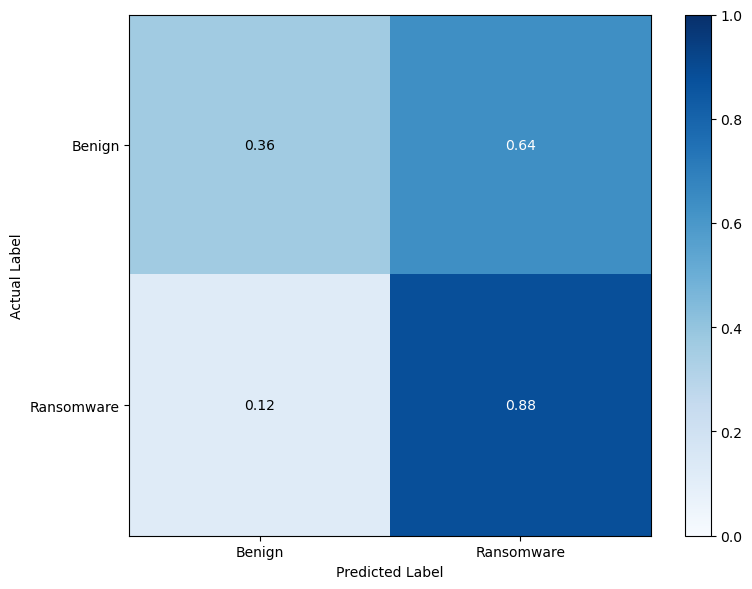

In [198]:
confusionMatrix_cnn_contour_aug = confusion_matrix(y_test_int, cnn_contour_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_contour_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_contour_aug.shape[0]):
    for j in range(confusionMatrix_cnn_contour_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_contour_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_contour_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [199]:
vit_contour_pred_int = evaluate(vit_contour, contour_test_dataloader, device)

In [200]:
print('Accuracy:', accuracy_score(y_test_int, vit_contour_pred_int))
print('Precision:', precision_score(y_test_int, vit_contour_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_contour_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_contour_pred_int, average='macro'))

Accuracy: 0.5849056603773585
Precision: 0.477124183006536
Recall: 0.46969696969696967
F1-Score: 0.4661172161172161


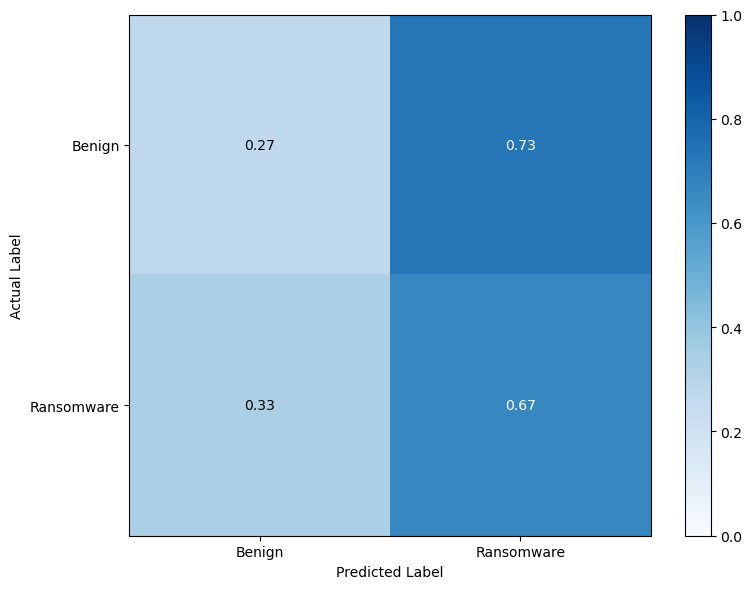

In [201]:
confusionMatrix_vit_contour = confusion_matrix(y_test_int, vit_contour_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_contour, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_contour.shape[0]):
    for j in range(confusionMatrix_vit_contour.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_contour[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_contour[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT with SMOTE

In [202]:
vit_contour_aug_pred_int = evaluate(vit_contour_aug, contour_test_dataloader, device)

In [203]:
print('Accuracy:', accuracy_score(y_test_int, vit_contour_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_contour_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_contour_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_contour_aug_pred_int, average='macro'))

Accuracy: 0.6792452830188679
Precision: 0.5952380952380952
Recall: 0.6298701298701299
F1-Score: 0.5965069413345275


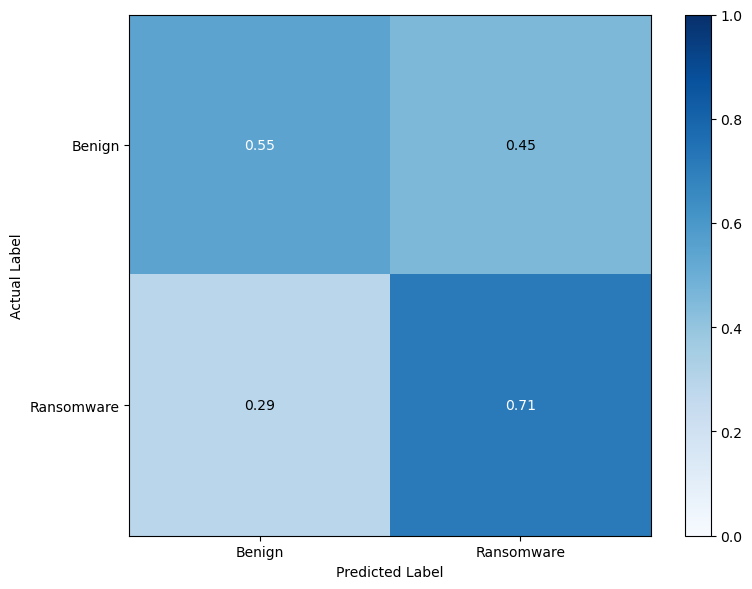

In [204]:
confusionMatrix_vit_contour_aug = confusion_matrix(y_test_int, vit_contour_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_contour_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_contour_aug.shape[0]):
    for j in range(confusionMatrix_vit_contour_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_contour_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_contour_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()